In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
from scipy.integrate import odeint, solve_ivp
from scipy.stats import entropy
from scipy.linalg import sinm, cosm, logm
from scipy.linalg import expm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sympy.physics.quantum import TensorProduct
from tqdm import tqdm
import cmath
%matplotlib inline
import qutip as qt
from scipy.stats import linregress
from scipy.linalg import fractional_matrix_power
import nashpy as nash
from sympy import *
import cvxpy as cp

In [2]:
import seaborn as sns
sns.set_style("darkgrid")
matplotlib.rcParams.update({'font.size': 22})

Define MMWU and associated helper functions

In [3]:
def GenerateRandDiagonal(seed=None, dim=2):
  np.random.seed(seed)
  A = np.random.rand(dim**2)
  return np.diag(A)

def GenerateRandHermitian(seed=None, dim1=2, dim2=2):
    np.random.seed(seed)
    # A = np.random.rand(dim**2, dim**2) + np.random.rand(dim**2, dim**2)*1j
    # B = A + A.conj().T
    B = qt.rand_herm(dim1*dim2, seed=seed).full()
    C = np.dot(B, np.conj(B).T)
    return C

def split_list(_list):
  half = len(_list)//2
  return _list[:half], _list[half:]

def is_pos_def(x):
  return np.all(np.round(np.linalg.eigvalsh(x), 10) >= 0)

In [4]:
def GetPhi(R, B, n):
    phi = np.trace(np.array(R@np.kron(np.eye(n), np.conj(B).T)).reshape(n,n,n,n), axis1=1, axis2=3)
    # if is_pos_def(phi):
    return phi
    # else:
    #   return None

def GetPhiDag(R, A, n):
    phi_dag = np.trace(np.array(np.kron(np.conj(A).T, np.eye(n))@R).reshape(n,n,n,n), axis1=0, axis2=2)
    # if is_pos_def(phi_dag):
    return phi_dag
    # else:
      # return None

In [5]:
def DiscreteTest(rho, sig, mu, alpha, R1, R2, n, m):
    rho_power = fractional_matrix_power(rho, 1/2)
    sig_power = fractional_matrix_power(sig, 1/2)
    # rho_power2 = fractional_matrix_power(rho, 2*alpha)
    # sig_power2 = fractional_matrix_power(sig, 2*alpha)

    # rho_j = rho/(np.trace(np.array(R1@np.kron(np.eye(n), np.conj(sig).T)).reshape(n, m, n, m), axis1=1, axis2=3))

    # phi_A_j = np.trace(np.array(R1@np.kron(np.eye(n), np.conj(sig).T)).reshape(n, m, n, m), axis1=1, axis2=3)
    phi_A_j = np.trace(np.array(R1@np.kron(np.eye(n), np.conj(sig).T)).reshape(n,n,n,n), axis1=1, axis2=3)
    rho_j = (rho_power@phi_A_j@rho_power)/np.trace(rho@phi_A_j)


    phi_B_j = np.trace(np.array(np.kron(np.conj(rho).T, np.eye(m))@R2).reshape(n, m, n, m), axis1=0, axis2=2)
    sig_j = (sig_power@phi_B_j@sig_power)/np.trace(sig@phi_B_j)

    exploitability = 1/2*(max(np.linalg.eigvalsh(phi_A_j)) - np.vdot(rho_j, phi_A_j) + max(np.linalg.eigvalsh(phi_B_j)) - np.vdot(phi_B_j, sig_j))  # np.trace(np.inner(rho_j, phi_A_j))
    # exploitability = max(np.linalg.eigvalsh(phi_A_j)) - np.vdot(R1, np.kron(rho_j, sig_j)) + max(np.linalg.eigvalsh(phi_B_j)) - np.vdot(R2, np.kron(rho_j, sig_j))

    return (rho_j, sig_j, exploitability, phi_A_j, phi_B_j)

In [6]:
def DiscreteDynamics(payoff1, payoff2, n, m, s, extra=1, N=5000, exponent=None, mu=0.1, alpha=0.5, print_avg=True, alternating=False):
    if payoff1.shape == (n,m):
        R1 = GetRMatrix(payoff1)
        R2 = GetRMatrix(payoff2)
    else:
        R1 = payoff1
        R2 = payoff2

    s1 = split_list(s)[0]#np.diag(split_list(s)[0])
    s2 = split_list(s)[1]#np.diag(split_list(s)[1]) #Might we just want to test with initial conditions = normalized identity? To simplify things?
    s_converted = np.concatenate([s1, s2])
    A = [s_converted[0:n**2].reshape(n,n)]
    B = [s_converted[n**2:2*n**2].reshape(n,n)]
    rho = [np.divide(A,np.trace(A[0]))[0]]
    sig = [np.divide(B,np.trace(B[0]))[0]]
    exploitability = []
    qcce_exploitability = []

    phi_A = []
    phi_B = []
    cumsum_rho = []
    cumsum_sig = []
    lyap = []
    lyap2 = []
    cumsum_phi = np.zeros((n,n), dtype=complex)
    cumsum_phi_dag = np.zeros((m,m), dtype=complex)
    cumsum_A = np.zeros((n,n), dtype=complex)
    cumsum_B = np.zeros((m,m), dtype=complex)

    for j in range(extra*N):
        if exponent is not None:
            if j<1:
                mu = np.log(2)
            else:
                mu = np.log(1+(1/(j+1)**(exponent)))
        else: mu=mu
        phi = GetPhi(R1, sig[j], n)
        if phi is None:
          print("phi none")
          break
        else:
          cumsum_phi += phi

        A = expm(mu*cumsum_phi)
        rho_new = A/np.trace(A)
        cumsum_A += rho_new
        cumsum_rho.append(cumsum_A)
        rho.append(rho_new)

        phi_dag = GetPhiDag(R2, rho[j], n)
        if phi_dag is None:
          print("phi dag none")
          break
        else:
          cumsum_phi_dag += phi_dag
        B = expm(mu*cumsum_phi_dag)
        sig_new = B/np.trace(B)
        cumsum_B += sig_new
        cumsum_sig.append(cumsum_B)
        sig.append(sig_new)

        # exp = 1/2*(max(np.linalg.eigvalsh(phi)) - np.vdot(rho_new, phi) + max(np.linalg.eigvalsh(phi_dag)) - np.vdot(phi_dag, sig_new))

        phi_A.append(phi)
        phi_B.append(phi_dag)
        # exploitability.append(exp)
        # print(exp)
        lyap_val = np.vdot(rho_new, phi) #np.vdot(R1, np.kron(rho_j, sig_j)) #np.trace(np.inner(R1, np.kron(rho_j, sig_j)))#np.trace(np.inner(phi_B_j, sig_j))
        lyap.append(lyap_val.real)
        lyap_val2 = np.vdot(phi, sig_new) #np.vdot(R2, np.kron(rho_j, sig_j)) #np.trace(np.inner(R2, np.kron(sig_j, rho_j)))
        lyap2.append(lyap_val2.real)

    # rho_avg = np.cumsum(rho)/np.arange(1, len(rho)+1)#running_avg(np.array(rho).T)
    # sig_avg = np.cumsum(sig)/np.arange(1, len(sig)+1)#running_avg(np.array(sig).T)
    joint_time_avg = []
    rho_time_avg = []
    sig_time_avg = []
    cumsum = np.cumsum(np.kron(rho,sig), axis=0)
    cumsum_rho = np.cumsum(rho, axis=0)
    cumsum_sig = np.cumsum(sig, axis=0)
#     print(cumsum)
    for k in range(len(cumsum_rho)):
        joint_time_avg.append(cumsum[k]/(k+1))
        rho_time_avg.append(cumsum_rho[k]/(k+1))
        sig_time_avg.append(cumsum_sig[k]/(k+1))
        
    for j in range(extra*N):
      rho_avg = rho[j]/(j+1)
      sig_avg = sig[j]/(j+1)
      exp = 1/2*(max(np.linalg.eigvalsh(phi_A[j])) - np.vdot(rho_avg, phi_A[j]) + max(np.linalg.eigvalsh(phi_B[j])) - np.vdot(sig_avg, phi_B[j]))
#     1/2*(max(np.linalg.eigvalsh(phi_A[j])) - np.vdot(rho_avg, phi_A[j]) + max(np.linalg.eigvalsh(phi_B[j])) - np.vdot(phi_B[j], sig_avg))
      qcce_exp = 1/2*(max(np.linalg.eigvalsh(phi_A[j])) - np.vdot(rho_time_avg[j], phi_A[j]) + max(np.linalg.eigvalsh(phi_B[j])) - np.vdot(sig_time_avg[j], phi_B[j]))
#         max(np.linalg.eigvalsh(np.kron(phi_A[j], phi_B[j]))) - np.vdot(joint_time_avg[j], np.kron(phi_A[j],phi_B[j]))
      exploitability.append(exp)
      qcce_exploitability.append(qcce_exp)
    # rho_avg = np.average(rho, axis=0)
    # sig_avg = np.average(sig, axis=0)

    # if print_avg:
    #   print('Number of iterations: ', N)
    #   print('Equilibrium rho: ', np.linalg.eigvals(rho_avg))
    #   print('Equilibrium sig: ', np.linalg.eigvals(sig_avg))

    data = {}
    data['R1'] = R1
    data['rho'] = rho
    data['sig'] = sig
    data['A'] = A
    data['B'] = B
    data['nash 1'] = rho_avg
    data['nash 2'] = sig_avg
    data['lyapunov'] = lyap
    data['lyapunov2'] = lyap2
    data['exploit'] = exploitability
    data['qcce_exploit'] = qcce_exploitability
    data['phi_A'] = phi_A
    data['phi_B'] = phi_B
    return data

In [7]:
def runSDPSolver(C1, C2, dim1=2, dim2=2):
    X = cp.Variable((dim1*dim2, dim1*dim2), complex=True)
    W1 = cp.partial_transpose(X, (dim1,dim2), axis=0)
    W2 = cp.partial_transpose(X, (dim1,dim2), axis=1)
    constraint = [W1 >> 0]
    constraint += [W2 >> 0]
    constraint += [cp.trace(X) == 1]
    constraint += [X >> 0]
    prob = cp.Problem(cp.Maximize(cp.real(cp.trace(C@X))),
                  constraint)
    prob.solve()
    print("Optimal value: ", prob.solution)
    return prob.value

In [8]:
def GetRandInit(n, complex=True):
  if complex:
    s1 = qt.rand_dm(n).full().flatten().tolist()
    s2 = qt.rand_dm(n).full().flatten().tolist()
  else:
    rand = np.random.rand(n)
    s1 = np.diag(np.array([rand[0], 1-rand[0]])).flatten().tolist()
    s2 = np.diag(np.array([rand[1], 1-rand[1]])).flatten().tolist()
  return s1+s2

In [9]:
def testRandomInitsDiscrete(R1, R2, n, numsteps, alpha=1/2, mu=0.1, exponent=None, alternating=False):
    lyap_vals = []
    exp_vals = []
    for i in tqdm(range(n)):
        s1 = qt.rand_dm(2, seed=i).full().flatten().tolist()
        s2 = qt.rand_dm(2, seed=i*2).full().flatten().tolist()

        s = s1+s2
        data = DiscreteDynamics(payoff1 = R1, payoff2 = R2, n=2, m=2, s=s, N=numsteps, mu=mu, update=update, alpha=alpha, exponent=exponent, alternating=alternating, print_avg=False)
        lyap = data['lyapunov']
        exploit = data['exploit']
        lyap_vals.append(lyap)
        exp_vals.append(exploit)
    plt.figure(figsize=(12,10))


    # plt.subplot(1, 2, 2)
    plt.plot(np.asarray(exp_vals).T)
    # plt.title('Exploitability')
    plt.xlabel("Time")
    plt.ylabel("Exploitability")
    # plt.legend(['x1','y1'], loc='best')
    # plt.grid();
    return

In [10]:
def generate_unif_init(dim):
  d = np.ones(dim)
  return np.diag(d/dim)

def generate_rand_init(dim):
  a = np.random.rand(dim)
  return np.diag(a/np.sum(a))

def GetPhi(R, B, n):
    phi = np.trace(np.array(R@np.kron(np.eye(n), np.conj(B).T)).reshape(n,n,n,n), axis1=1, axis2=3)
    # if is_pos_def(phi):
    return phi
    # else:
    #   return None

def GetPhiDag(R, A, n):
    phi_dag = np.trace(np.array(R@np.kron(np.conj(A).T, np.eye(n))).reshape(n,n,n,n), axis1=0, axis2=2)
    # if is_pos_def(phi_dag):
    return phi_dag
    # else:
      # return None

In [11]:
def DiscreteDynamicsDoubled(R1, R2, n, m, s, segments=1, N=500, exponent=None, mu=0.1, alpha=0.5, print_avg=True, alternating=False):
    s1 = split_list(s)[0]#np.diag(split_list(s)[0]) 
    s2 = split_list(s)[1]#np.diag(split_list(s)[1])
    s_converted = np.concatenate([s1, s2])      
    A = [s_converted[0:n**2].reshape(n,n)]
    B = [s_converted[n**2:2*n**2].reshape(n,n)]
    rho = [np.divide(A,np.trace(A[0]))[0]]
    sig = [np.divide(B,np.trace(B[0]))[0]]
    exploitability = []
    qcce_exploitability = []
    
    phi_A = []
    phi_B = []
    cumsum_rho = []
    cumsum_sig = []
    lyap = []
    lyap2 = []
    cumsum_phi = np.zeros((n,n), dtype=complex)
    cumsum_phi_dag = np.zeros((m,m), dtype=complex)
    cumsum_A = np.zeros((n,n), dtype=complex)
    cumsum_B = np.zeros((m,m), dtype=complex)
    
    for k in range(segments):
        for j in range((2**k)*N):
            if exponent is not None:
                if j<1:
                    mu = np.log(2)
                else:
                    mu = np.log(1+(1/(j+1)**(exponent)))
            else: mu=mu
            phi = GetPhi(R1, sig[j], n)
            if phi is None:
              print("phi none")
              break
            else:
              cumsum_phi += phi
            A = expm(mu*cumsum_phi)
            rho_new = A/np.trace(A)
            cumsum_A += rho_new
            cumsum_rho.append(cumsum_A)
            rho.append(rho_new)
    #         print(sig[j])
    #         print(R2)
    #         print(rho[j])
            phi_dag = GetPhiDag(R2, rho[j], n)
            if phi_dag is None:
              print("phi dag none")
              break
            else:
              cumsum_phi_dag += phi_dag
            B = expm(mu*cumsum_phi_dag)
            sig_new = B/np.trace(B)
            cumsum_B += sig_new
            cumsum_sig.append(cumsum_B)
            sig.append(sig_new)

            phi_A.append(phi)
            phi_B.append(phi_dag)
            # exploitability.append(exp)
            # print(exp)
            lyap_val = np.vdot(rho_new, phi) #np.vdot(R1, np.kron(rho_j, sig_j)) #np.trace(np.inner(R1, np.kron(rho_j, sig_j)))#np.trace(np.inner(phi_B_j, sig_j))
            lyap.append(lyap_val.real)
            lyap_val2 = np.vdot(phi, sig_new) #np.vdot(R2, np.kron(rho_j, sig_j)) #np.trace(np.inner(R2, np.kron(sig_j, rho_j)))
            lyap2.append(lyap_val2.real)
    
    joint_time_avg = []
    rho_time_avg = []
    sig_time_avg = []
    phi_A_avg = []
    phi_B_avg = []
    cumsum = np.cumsum(np.kron(rho,sig), axis=0)
    cumsum_rho = np.cumsum(rho, axis=0)
    cumsum_sig = np.cumsum(sig, axis=0)
#     print(cumsum)
    for y in range(len(cumsum_rho)):
        joint_time_avg.append(cumsum[y]/(y+1))
        rho_time_avg.append(cumsum_rho[y]/(y+1))
        sig_time_avg.append(cumsum_sig[y]/(y+1))
        phi_A_avg.append(GetPhi(R1,cumsum_sig[y]/(y+1),n))
        phi_B_avg.append(GetPhiDag(R2,cumsum_rho[y]/(y+1),m))
    for j in range((2**k)*N):
      rho_avg = rho[j]/(j+1)
      sig_avg = sig[j]/(j+1)
      exp = max(max(np.linalg.eigvalsh(phi_A[j])) - np.vdot(rho_time_avg[j], phi_A[j]), max(np.linalg.eigvalsh(phi_B[j])) - np.vdot(phi_B[j], sig_time_avg[j]))
      qcce_exp = max(max(np.linalg.eigvalsh(phi_A_avg[j])) - np.vdot(rho_time_avg[j], phi_A_avg[j]), max(np.linalg.eigvalsh(phi_B_avg[j])) - np.vdot(sig_time_avg[j], phi_B_avg[j]))
      exploitability.append(exp)
      qcce_exploitability.append(qcce_exp)
        
    if print_avg:    
      print('Number of iterations: ', N)
#       print('Equilibrium rho: ', np.linalg.eigvals(rho_avg))
#       print('Equilibrium sig: ', np.linalg.eigvals(sig_avg))
    
    data = {}
    data['R1'] = R1
    data['rho'] = rho
    data['sig'] = sig
    data['A'] = A
    data['B'] = B
    data['nash 1'] = rho_avg
    data['nash 2'] = sig_avg
    data['lyapunov'] = lyap
    data['lyapunov2'] = lyap2
    data['exploit'] = exploitability
    data['qcce_exploit'] = qcce_exploitability
    data['phi_A'] = phi_A
    data['phi_B'] = phi_B
    return data

In [12]:
def running_avg(arr):
  cumsums=[]
  for x in arr:
      cumsums.append(np.cumsum(x)/np.arange(1, len(x)+1))
  return cumsums

In [13]:
s = (generate_unif_init(2)).flatten().tolist()*2
R = GenerateRandHermitian(seed = 41, dim1= 2, dim2=2)
R2 = GenerateRandHermitian(seed = 4, dim1= 2, dim2=2)
discrete1 = DiscreteDynamicsDoubled(R, R2, s=s, n=2, m=2, N=300, mu=0.5)

Number of iterations:  300


In [14]:
s = (generate_unif_init(2)).flatten().tolist()*2
R = GenerateRandHermitian(seed = 41, dim1= 2, dim2=2)
R2 = GenerateRandHermitian(seed = 4, dim1= 2, dim2=2)
discrete1 = DiscreteDynamicsDoubled(R, -R, s=s, n=2, m=2, N=300, mu=0.5)

Number of iterations:  300


<Figure size 1200x1000 with 0 Axes>

C:\Users\Ryann\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Time')

Text(0, 0.5, 'Exploitability')

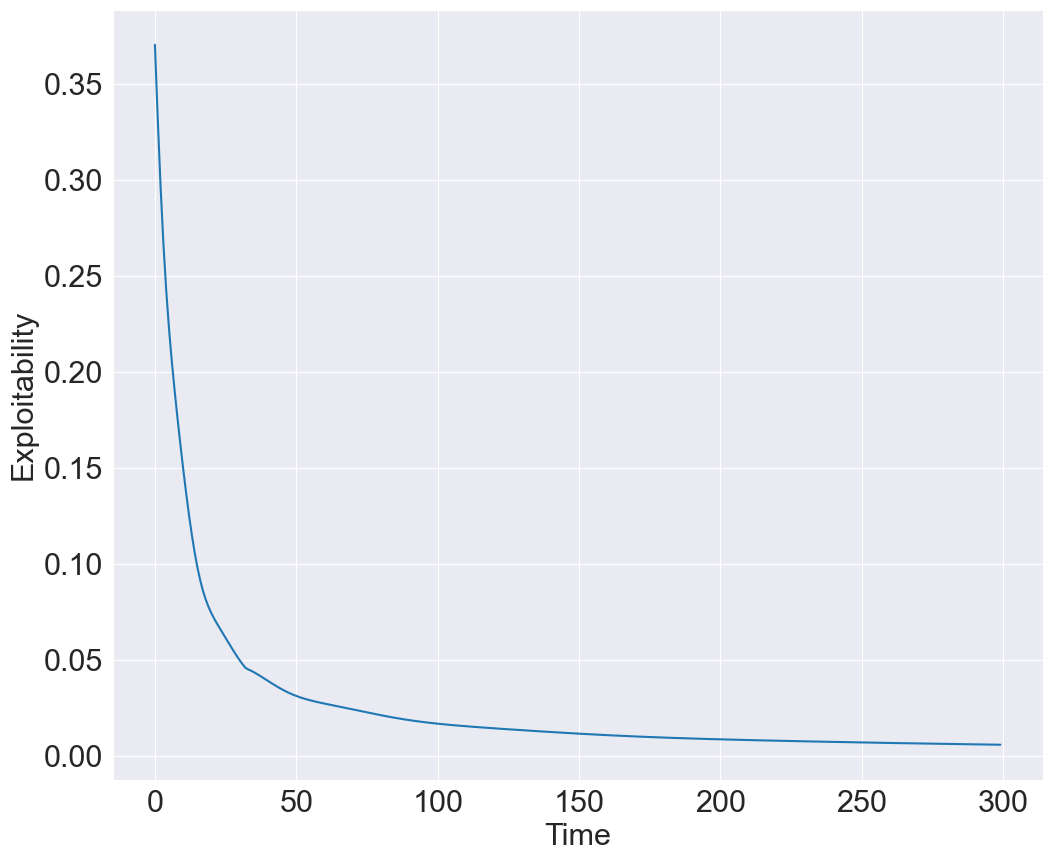

In [15]:
plt.figure(figsize=(12,10))
# x = running_avg([np.array(discrete1['exploit']).T])
plt.plot(np.array(discrete1['qcce_exploit']).T)
plt.xlabel("Time")
plt.ylabel("Exploitability")
# plt.ylim(0,0.6)

In [16]:
def generate_unif_init(dim):
  d = np.ones(dim)
  return np.diag(d/dim)

def generate_rand_init(dim):
  a = np.random.rand(dim)
  return np.diag(a/np.sum(a))

In [41]:
def MultipleRuns(dim1=2, dim2=2, runs=50, numsteps=50, unif=True, seed=0, print_stats=True, qcce=False, zs=True):
  vals = []
  for i in range(runs):
      if unif:
          s1 = generate_unif_init(dim1)#.flatten().tolist()
          # print(s1)
          # s2 = generate_unif_init(m)#.flatten().tolist()
      else:
        r1 = 0.45 + (0.55 - 0.45)*np.random.rand()
        s1 = qt.rand_dm(dim1).full()#.flatten().tolist()
        s1[0,0] = r1
        s1[1,1] = 1-r1
        # print(np.diag(s1))
        # s2 = qt.rand_herm(m).full()
      s = (s1).flatten().tolist()*2
      # print(s)
      print('Run: ', str(i))
      R1 = GenerateRandHermitian(seed = i, dim1= dim1, dim2=dim2)
      R2 = GenerateRandHermitian(seed = i*2, dim1= dim1, dim2=dim2)
      if not zs:
        discrete = DiscreteDynamicsDoubled(R1 = R1, R2 = R2, s=s, n=dim1, m=dim2, N=numsteps, mu=0.5)#, exponent=3/4)
      else:
        discrete = DiscreteDynamicsDoubled(R1 = R1, R2 = -R1, s=s, n=dim1, m=dim2, N=numsteps, mu=0.5, exponent=1/2)
      print('\n')
      # print(discrete['lyapunov'][-1]/val1)
      if qcce:
        vals.append(discrete['qcce_exploit'])
      else:
        vals.append(discrete['exploit'])
  return vals

In [18]:
exploit1qcce = MultipleRuns(runs=20, numsteps=1000, unif=True, qcce=True, zs=False)

Run:  0


C:\Users\Ryann\Anaconda3\lib\site-packages\scipy\linalg\_matfuncs.py:320: RuntimeWarning: overflow encountered in multiply
  eA[..., [1], [1]] = eApD2 * (coshMu - AmD2*sinchMu)
C:\Users\Ryann\AppData\Local\Temp\ipykernel_18100\589497220.py:38: RuntimeWarning: invalid value encountered in divide
  rho_new = A/np.trace(A)
C:\Users\Ryann\AppData\Local\Temp\ipykernel_18100\589497220.py:52: RuntimeWarning: invalid value encountered in divide
  sig_new = B/np.trace(B)
C:\Users\Ryann\Anaconda3\lib\site-packages\numpy\lib\scimath.py:135: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
C:\Users\Ryann\Anaconda3\lib\site-packages\scipy\linalg\_matfuncs.py:315: RuntimeWarning: invalid value encountered in divide
  sinchMu[mask] = np.sinh(mu[mask]) / mu[mask]


Number of iterations:  1000


Run:  1
Number of iterations:  1000


Run:  2


C:\Users\Ryann\Anaconda3\lib\site-packages\scipy\linalg\_matfuncs.py:317: RuntimeWarning: overflow encountered in multiply
  eA[..., [0], [0]] = eApD2 * (coshMu + AmD2*sinchMu)
C:\Users\Ryann\Anaconda3\lib\site-packages\scipy\linalg\_matfuncs.py:318: RuntimeWarning: overflow encountered in multiply
  eA[..., [0], [1]] = eApD2 * a2 * sinchMu
C:\Users\Ryann\Anaconda3\lib\site-packages\scipy\linalg\_matfuncs.py:319: RuntimeWarning: overflow encountered in multiply
  eA[..., [1], [0]] = eApD2 * a3 * sinchMu


Number of iterations:  1000


Run:  3
Number of iterations:  1000


Run:  4


C:\Users\Ryann\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:1774: RuntimeWarning: overflow encountered in reduce
  return asanyarray(a).trace(offset=offset, axis1=axis1, axis2=axis2, dtype=dtype, out=out)


Number of iterations:  1000


Run:  5
Number of iterations:  1000


Run:  6
Number of iterations:  1000


Run:  7
Number of iterations:  1000


Run:  8
Number of iterations:  1000


Run:  9
Number of iterations:  1000


Run:  10
Number of iterations:  1000


Run:  11
Number of iterations:  1000


Run:  12
Number of iterations:  1000


Run:  13
Number of iterations:  1000


Run:  14
Number of iterations:  1000


Run:  15
Number of iterations:  1000


Run:  16
Number of iterations:  1000


Run:  17
Number of iterations:  1000


Run:  18
Number of iterations:  1000


Run:  19
Number of iterations:  1000




C:\Users\Ryann\AppData\Local\Temp\ipykernel_18100\564746729.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(0,len(exploit1qcce[0])-1), 2/np.sqrt(np.arange(0,len(exploit1qcce[0])-1)),label='Regret Bound',color='black', linestyle='dashed');


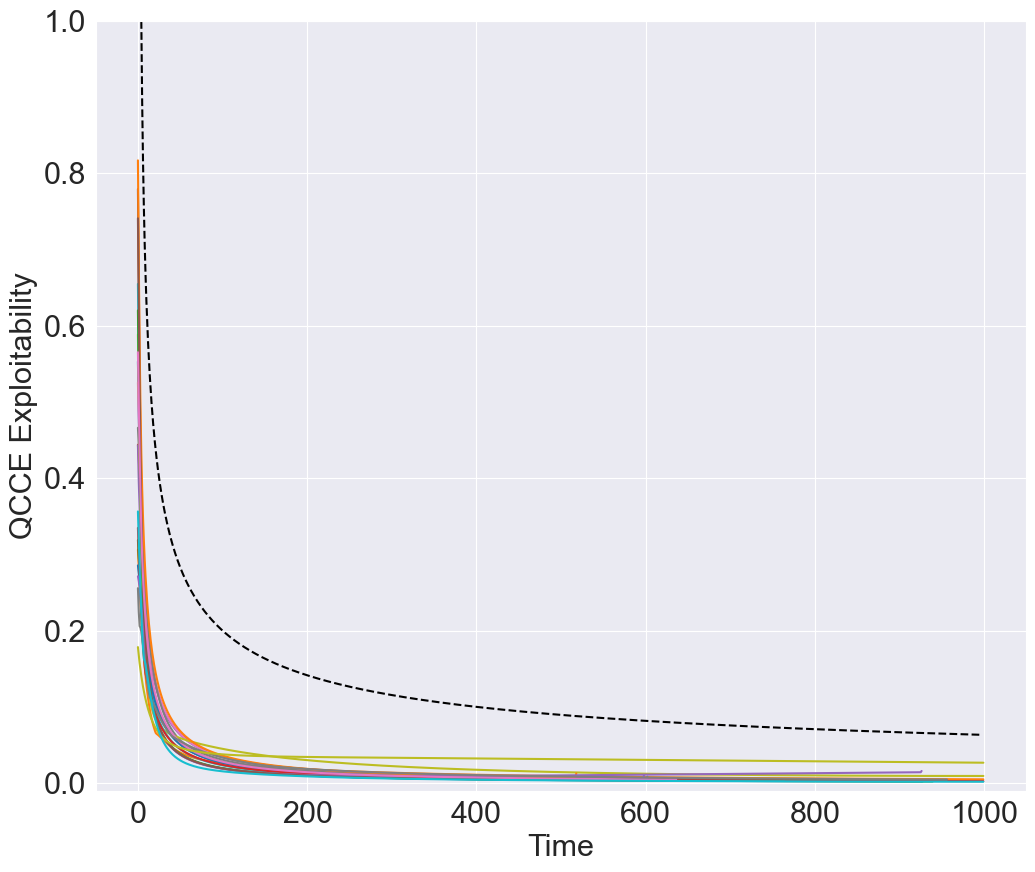

In [19]:
plt.figure(figsize=(12,10));
plt.plot(np.asarray(exploit1qcce).T);
plt.plot(np.arange(0,len(exploit1qcce[0])-1), 2/np.sqrt(np.arange(0,len(exploit1qcce[0])-1)),label='Regret Bound',color='black', linestyle='dashed');
plt.xlabel("Time");
plt.ylabel("QCCE Exploitability");
plt.ylim(-0.01, 1);

In [20]:
exploit1 = MultipleRuns(runs=20, numsteps=1000, unif=True, zs=True)

Run:  0
Number of iterations:  1000


Run:  1
Number of iterations:  1000


Run:  2
Number of iterations:  1000


Run:  3
Number of iterations:  1000


Run:  4
Number of iterations:  1000


Run:  5
Number of iterations:  1000


Run:  6
Number of iterations:  1000


Run:  7
Number of iterations:  1000


Run:  8
Number of iterations:  1000


Run:  9
Number of iterations:  1000


Run:  10
Number of iterations:  1000


Run:  11
Number of iterations:  1000


Run:  12
Number of iterations:  1000


Run:  13
Number of iterations:  1000


Run:  14
Number of iterations:  1000


Run:  15
Number of iterations:  1000


Run:  16
Number of iterations:  1000


Run:  17
Number of iterations:  1000


Run:  18
Number of iterations:  1000


Run:  19
Number of iterations:  1000




C:\Users\Ryann\AppData\Local\Temp\ipykernel_18100\1358675233.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.arange(0,len(exploit1[0])-1), 2/np.sqrt(np.arange(0,len(exploit1[0])-1)),label='Regret Bound',color='black', linestyle='dashed');


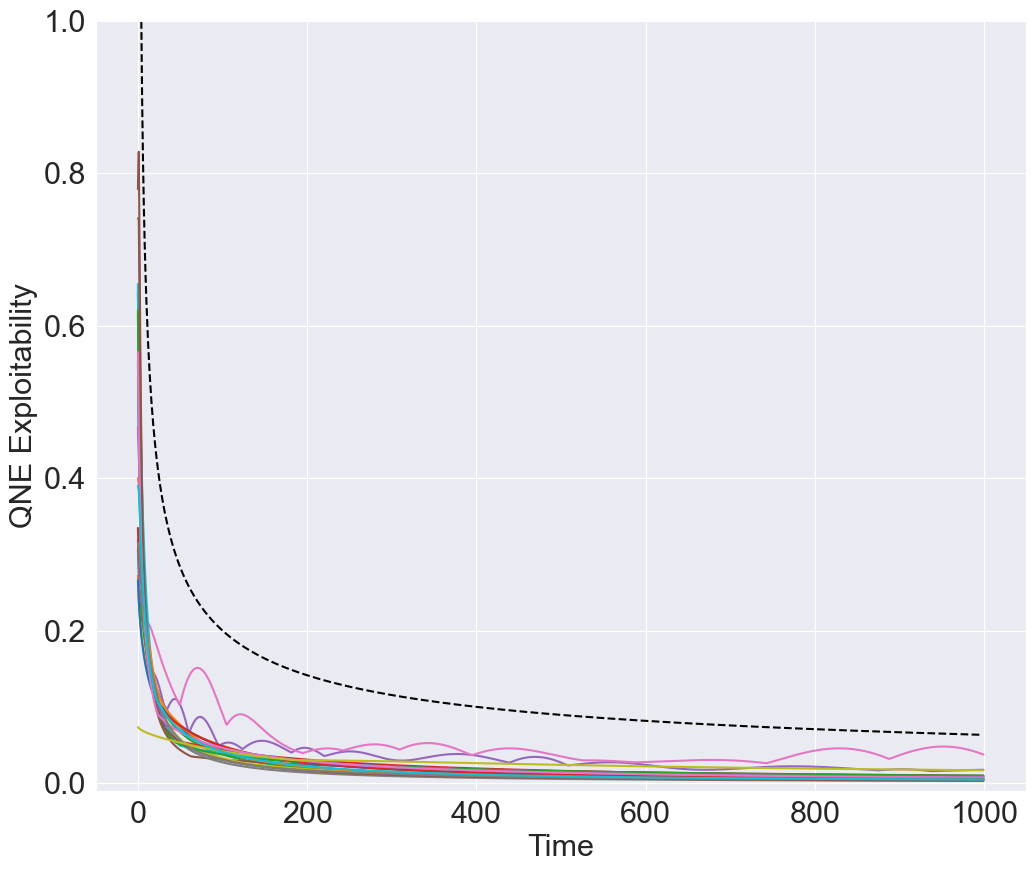

In [21]:
plt.figure(figsize=(12,10));
plt.plot(np.asarray(exploit1).T);
plt.plot(np.arange(0,len(exploit1[0])-1), 2/np.sqrt(np.arange(0,len(exploit1[0])-1)),label='Regret Bound',color='black', linestyle='dashed');
plt.xlabel("Time");
plt.ylabel("QNE Exploitability");
plt.ylim(-0.01,1);